In [172]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Model Prediction Task 1

In [173]:
datasets = [os.path.join('data', file) for file in os.listdir('data') if file.endswith('.csv')]
datasets.sort()

In [174]:
datasets

['data/resale-flat-prices-based-on-approval-date-1990-1999.csv',
 'data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv',
 'data/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv',
 'data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv',
 'data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv']

In [175]:
dfs = []
for file in datasets:
    df = pd.read_csv(file)
    dfs.append(df)

In [176]:
hdb_prices = pd.concat(dfs, ignore_index=True)

#copy
hdb_prices_original = hdb_prices.copy()

In [177]:
hdb_prices.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN


In [178]:
hdb_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826581 entries, 0 to 826580
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                826581 non-null  object 
 1   town                 826581 non-null  object 
 2   flat_type            826581 non-null  object 
 3   block                826581 non-null  object 
 4   street_name          826581 non-null  object 
 5   storey_range         826581 non-null  object 
 6   floor_area_sqm       826581 non-null  float64
 7   flat_model           826581 non-null  object 
 8   lease_commence_date  826581 non-null  int64  
 9   resale_price         826581 non-null  float64
 10  remaining_lease      117527 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 69.4+ MB


In [179]:
# lowercase and remove spaces or hyphens
hdb_prices['flat_type'] = hdb_prices['flat_type'].str.lower().str.replace(' ', '_').str.replace('-', '_')
hdb_prices.flat_type.value_counts()

flat_type
4_room              309314
3_room              272580
5_room              170408
executive            62641
2_room                9863
1_room                1273
multi_generation       502
Name: count, dtype: int64

In [180]:
hdb_prices.storey_range.value_counts()

storey_range
04 TO 06    209705
07 TO 09    189109
01 TO 03    168985
10 TO 12    160250
13 TO 15     52212
16 TO 18     19449
19 TO 21      9422
22 TO 24      6053
01 TO 05      2700
25 TO 27      2544
06 TO 10      2474
11 TO 15      1259
28 TO 30      1049
34 TO 36       267
31 TO 33       265
16 TO 20       265
37 TO 39       255
40 TO 42       132
21 TO 25        92
26 TO 30        39
46 TO 48        21
43 TO 45        16
49 TO 51         9
36 TO 40         7
31 TO 35         2
Name: count, dtype: int64

In [181]:
#lowercase and replace spaces with underscores for categorical features
hdb_prices['flat_model'] = hdb_prices['flat_model'].str.lower().str.replace(' ', '_').str.replace('-', '_')
hdb_prices.flat_model.value_counts()

flat_model
model_a                   228389
improved                  217356
new_generation            177570
simplified                 53960
standard                   39854
premium_apartment          35035
apartment                  32004
maisonette                 26909
model_a2                    9109
model_a_maisonette          1889
dbss                        1609
adjoined_flat               1085
terrace                      642
multi_generation             502
type_s1                      272
type_s2                      129
improved_maisonette          114
premium_maisonette            82
2_room                        40
premium_apartment_loft        31
Name: count, dtype: int64

In [182]:
hdb_prices['date_clean'] = pd.to_datetime(hdb_prices['month'], format='%Y-%m')

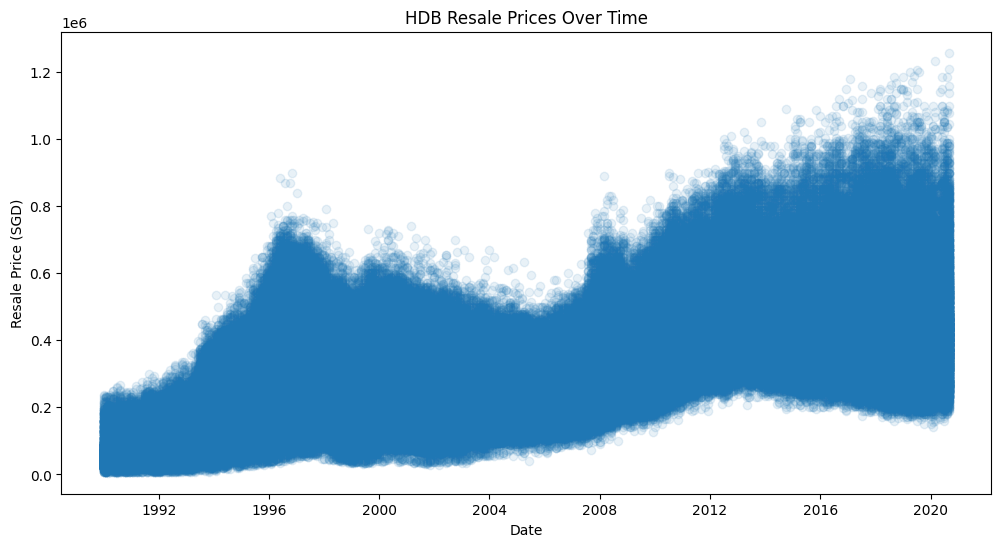

In [183]:
# plot scatter plot of prices over time
plt.figure(figsize=(12, 6))
plt.scatter(hdb_prices['date_clean'], hdb_prices['resale_price'], alpha=0.1)
plt.title('HDB Resale Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Resale Price (SGD)')
plt.show()

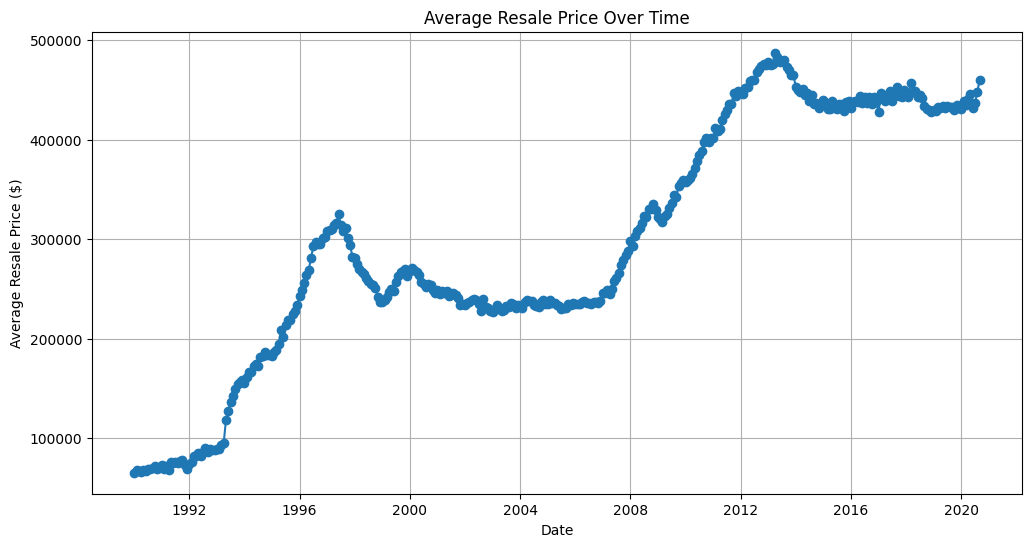

In [184]:
monthly_avg = hdb_prices.groupby('date_clean')['resale_price'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['date_clean'], monthly_avg['resale_price'], marker='o', linestyle='-')
plt.title('Average Resale Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Resale Price ($)')
plt.grid(True)

In [185]:
# Calculate average price per flat type per month
pivot_df = hdb_prices.groupby(['month', 'flat_type'])['resale_price'].mean().unstack()
pivot_df.head()

flat_type,1_room,2_room,3_room,4_room,5_room,executive,multi_generation
month,,,,,,,
1990-01,7711.111111,18550.0,41445.067416,79955.134328,133867.914439,183312.500000,NaN
1990-02,7733.333333,18828.0,43268.710938,81961.310044,131307.815126,178708.823529,NaN
1990-03,7366.666667,18325.0,42876.886503,80175.407407,128024.231788,183615.789474,NaN
1990-04,8166.666667,19012.0,42378.292683,82460.598291,126182.553191,185479.310345,NaN
1990-05,8450.000000,18868.0,42226.157407,83309.644670,135086.359551,192362.068966,NaN


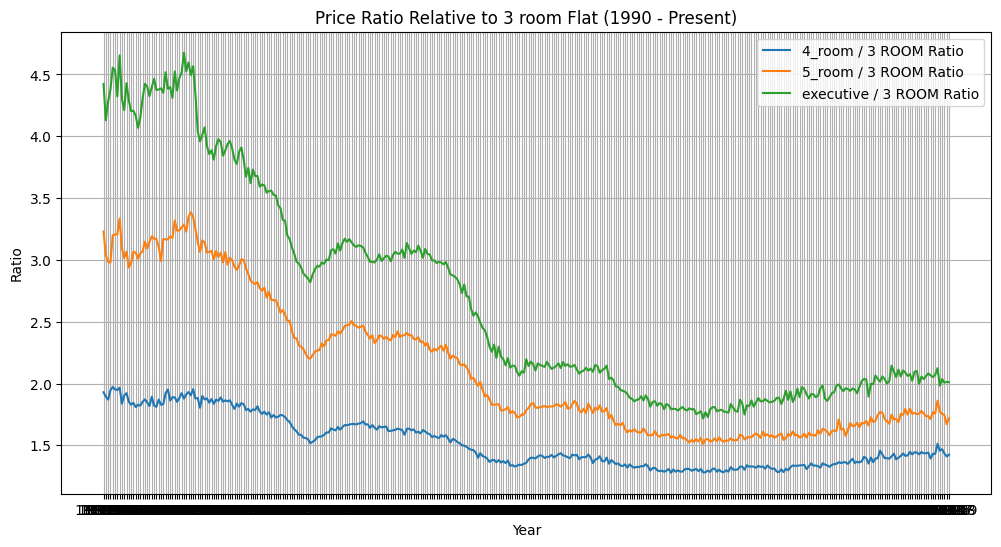

In [186]:
# normalize by 3 room price to see the ratio
pivot_ratio = pivot_df.div(pivot_df['3_room'], axis=0)

# Plot the ratios
plt.figure(figsize=(12, 6))
for col in ['4_room', '5_room', 'executive']:
    if col in pivot_ratio.columns:
        plt.plot(pivot_ratio.index, pivot_ratio[col], label=f'{col} / 3 ROOM Ratio')

plt.title('Price Ratio Relative to 3 room Flat (1990 - Present)')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [187]:
# Check unique storey_ranges for first and last file
print("Unique storey_range in 1990-1999:", sorted(dfs[0]['storey_range'].unique()))
print("Unique storey_range in 2017-onwards:", sorted(dfs[-1]['storey_range'].unique()))

Unique storey_range in 1990-1999: ['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15', '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27']
Unique storey_range in 2017-onwards: ['01 TO 03', '01 TO 05', '04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12', '11 TO 15', '13 TO 15', '16 TO 18', '16 TO 20', '19 TO 21', '21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30', '31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40', '37 TO 39', '40 TO 42']


Based on my data exploration, I have decided to limit the data used for training the model to HDB resale listings from 2013 onwards.

- The average resale price has changed drastically over the years, from slow and gradual growth from 1990 to 2007, to massive price spikes from 2008 to 2012, and finally a more stabilised average price from 2013 onwards. If we use data from 1990 to 2012, the model might learn a long-term upwards trend which is more muted in today's context.
- The Price Ratio Plot also shows that the relative value in flat types has changed drastically over the years. For example the "premium" of a 5-room flat over a 3-room flat was at almost 3 times the price, whereas it is closer to 1.8 times today.

Since we are trying to find ways to curb housing price inflation and not model long-term historical inflation, we will drop old data as they will likely introduce more noise and bias.

In [188]:
hdb_prices_recent = hdb_prices[hdb_prices['date_clean'] >= '2013-01-01'].copy()

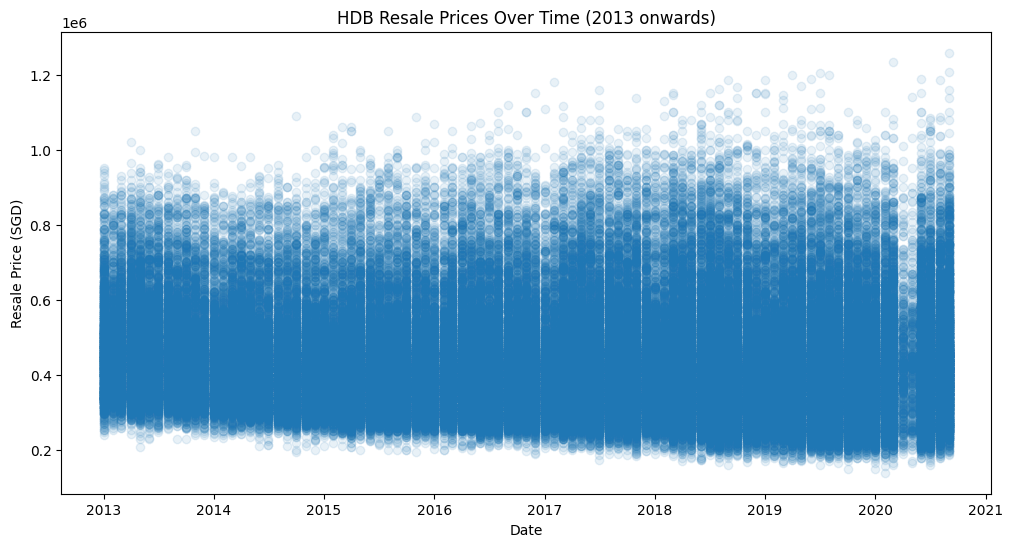

In [189]:
# plot scatter plot of prices over time
plt.figure(figsize=(12, 6))
plt.scatter(hdb_prices_recent['date_clean'], hdb_prices_recent['resale_price'], alpha=0.1)
plt.title('HDB Resale Prices Over Time (2013 onwards)')
plt.xlabel('Date')
plt.ylabel('Resale Price (SGD)')

plt.show()

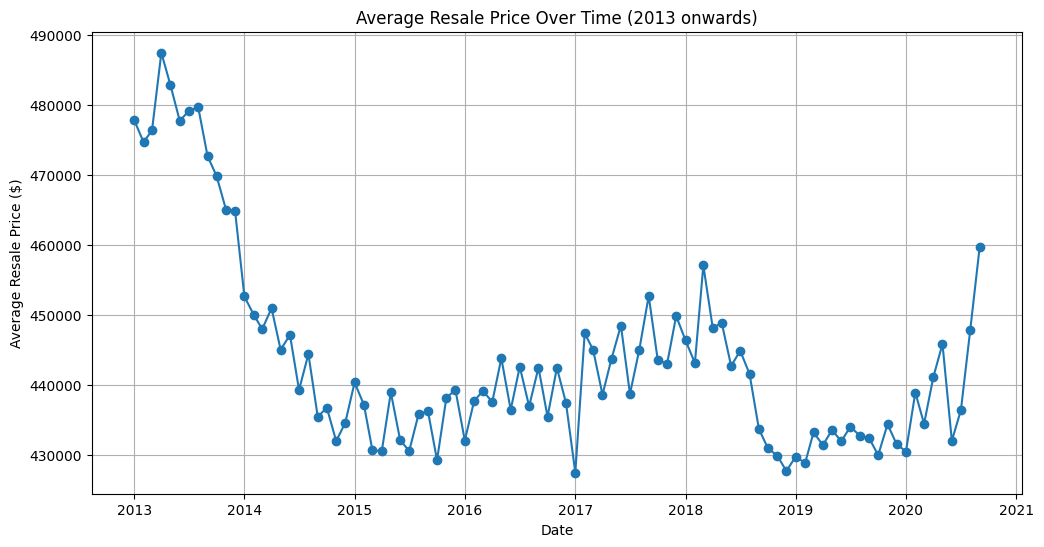

In [230]:
monthly_avg = hdb_prices_recent.groupby('date_clean')['resale_price'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['date_clean'], monthly_avg['resale_price'], marker='o', linestyle='-')
plt.title('Average Resale Price Over Time (2013 onwards)')
plt.xlabel('Date')
plt.ylabel('Average Resale Price ($)')
plt.grid(True)

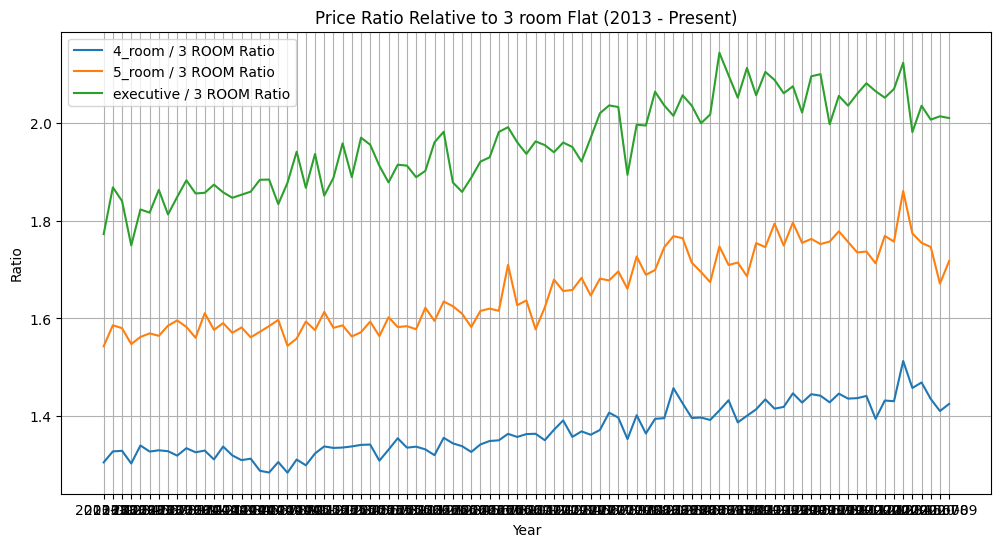

In [232]:
# normalize by 3 room price to see the ratio
pivot_df = hdb_prices_recent.groupby(['month', 'flat_type'])['resale_price'].mean().unstack()
pivot_ratio = pivot_df.div(pivot_df['3_room'], axis=0)

# Plot the ratios
plt.figure(figsize=(12, 6))
for col in ['4_room', '5_room', 'executive']:
    if col in pivot_ratio.columns:
        plt.plot(pivot_ratio.index, pivot_ratio[col], label=f'{col} / 3 ROOM Ratio')

plt.title('Price Ratio Relative to 3 room Flat (2013 - Present)')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [190]:
# feature engineering functions
def parse_remaining_lease(month, lease_commence_date):
    years = int(month.split('-')[0])
    months = int(month.split('-')[1])
    lease_start_year = int(lease_commence_date)
    years_passed = years - lease_start_year
    # assume all leases are 99 years
    return 99 - (years_passed + months/12.0)

def parse_storey(val):
    try:
        start, end = val.split(' TO ')
        return (int(start) + int(end)) / 2
    except: return 0

In [191]:
min_date = hdb_prices_recent['date_clean'].min()
hdb_prices_recent['months_since_start'] = (hdb_prices_recent['date_clean'].dt.year - min_date.year) * 12 + \
                           (hdb_prices_recent['date_clean'].dt.month - min_date.month)

In [192]:
hdb_prices_recent['remaining_lease_years'] = hdb_prices_recent.apply(lambda row: parse_remaining_lease(row['month'], row['lease_commence_date']), axis=1)
hdb_prices_recent['storey_mid'] = hdb_prices_recent['storey_range'].apply(parse_storey)

In [193]:
hdb_prices_recent.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,date_clean,months_since_start,remaining_lease_years,storey_mid
656851,2015-01,ANG MO KIO,3_room,174,ANG MO KIO AVE 4,07 TO 09,60.0,improved,1986,255000.0,70,2015-01-01,24,69.916667,8.0
656852,2015-01,ANG MO KIO,3_room,541,ANG MO KIO AVE 10,01 TO 03,68.0,new_generation,1981,275000.0,65,2015-01-01,24,64.916667,2.0
656853,2015-01,ANG MO KIO,3_room,163,ANG MO KIO AVE 4,01 TO 03,69.0,new_generation,1980,285000.0,64,2015-01-01,24,63.916667,2.0
656854,2015-01,ANG MO KIO,3_room,446,ANG MO KIO AVE 10,01 TO 03,68.0,new_generation,1979,290000.0,63,2015-01-01,24,62.916667,2.0
656855,2015-01,ANG MO KIO,3_room,557,ANG MO KIO AVE 10,07 TO 09,68.0,new_generation,1980,290000.0,64,2015-01-01,24,63.916667,8.0


In [194]:
hdb_prices_recent['remaining_lease_years'].describe()

count    149720.000000
mean         74.122451
std          11.822307
min          44.333333
25%          65.000000
50%          72.916667
75%          83.250000
max          97.750000
Name: remaining_lease_years, dtype: float64

In [195]:
hdb_prices_recent.storey_mid.describe()

count    149720.000000
mean          8.316270
std           5.485684
min           2.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          50.000000
Name: storey_mid, dtype: float64

In [196]:
hdb_prices_recent[['months_since_start', 'storey_mid', 'floor_area_sqm', 
                      'remaining_lease_years']].corr()

,months_since_start,storey_mid,floor_area_sqm,remaining_lease_years
months_since_start,1.000000,0.055079,0.026535,-0.001607
storey_mid,0.055079,1.000000,0.027583,0.258382
floor_area_sqm,0.026535,0.027583,1.000000,0.285963
remaining_lease_years,-0.001607,0.258382,0.285963,1.000000


In [197]:
categorical_features = ['town', 'flat_model']
numerical_features = ['months_since_start', 'storey_mid', 'floor_area_sqm', 
                      'remaining_lease_years']
ordinal_features = ['flat_type']

hdb_prices_recent = hdb_prices_recent.sort_values(by='date_clean').reset_index(drop=True)


In [198]:
X = hdb_prices_recent[numerical_features + categorical_features + ordinal_features]
y = hdb_prices_recent['resale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False  #for time series data
)

In [199]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('ord', OrdinalEncoder(categories=[[ '1_room', '2_room', '3_room', '4_room', 
    '5_room','executive','multi_generation']]), ordinal_features)
    ],
    verbose_feature_names_out=False
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()


In [200]:
# Using a Random Forest Regressor as a baseline model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [201]:
# training error
y_train_pred = rf.predict(X_train_encoded)
train_rmse = np.sqrt(mean_absolute_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")

Training RMSE: 97.26
Training MAE: 9460.25


In [202]:
# evaluation
y_pred = rf.predict(X_test_encoded)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print(f"R2 Score: {rf.score(X_test_encoded, y_test):.4f}")

RMSE: $45,656.91
MAE: $30,838.15
R2 Score: 0.9104



Top 10 Features:
                  Feature  Importance
2          floor_area_sqm    0.485485
1              storey_mid    0.109290
3   remaining_lease_years    0.081911
8        town_BUKIT MERAH    0.038777
0      months_since_start    0.037086
22        town_QUEENSTOWN    0.026169
6             town_BISHAN    0.022992
28         town_WOODLANDS    0.017400
18   town_KALLANG/WHAMPOA    0.012722
11      town_CENTRAL AREA    0.012532


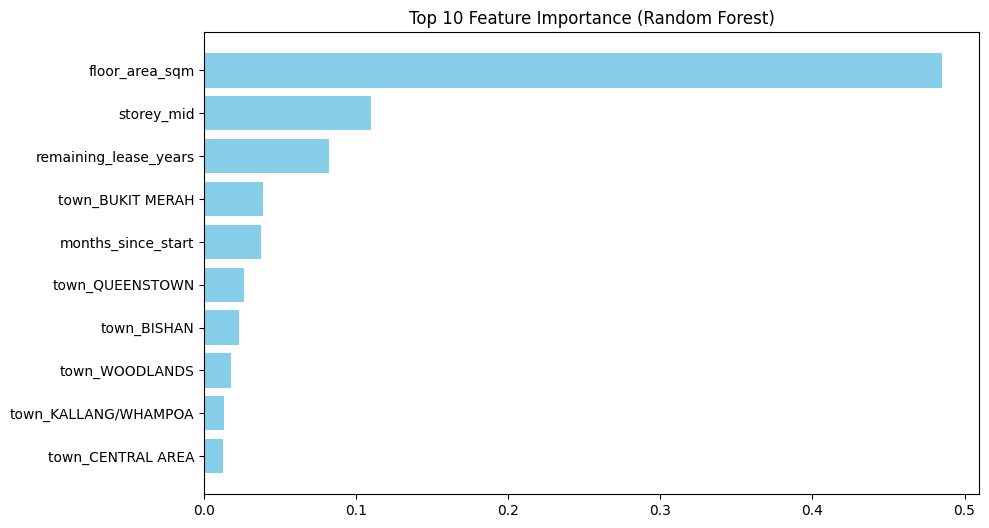

In [203]:
#random forest feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nTop 10 Features:")
print(importance_df)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importance (Random Forest)')
plt.show()

In [ ]:
# Further split test set into eval and final test sets for early stopping for lightGBM
X_eval, X_test, y_eval, y_test = train_test_split(
    X_test, y_test,
    test_size=0.5,
    shuffle=False
)

In [224]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', 'passthrough', categorical_features),
        ('ord', OrdinalEncoder(categories=[[ '1_room', '2_room', '3_room', '4_room', 
    '5_room','executive','multi_generation']]), ordinal_features)
    ],
    verbose_feature_names_out=False
)


X_train_encoded = pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())
X_eval_encoded = pd.DataFrame(preprocessor.transform(X_eval), columns = preprocessor.get_feature_names_out())
X_test_encoded = pd.DataFrame(preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())

# convert categorical features to categorical dtype
for col in categorical_features:
    X_train_encoded[col] = X_train_encoded[col].astype('category')
    X_eval_encoded[col] = X_eval_encoded[col].astype('category')
    X_test_encoded[col] = X_test_encoded[col].astype('category')

for col in numerical_features + ordinal_features:
    X_train_encoded[col] = pd.to_numeric(X_train_encoded[col])
    X_eval_encoded[col] = pd.to_numeric(X_eval_encoded[col])
    X_test_encoded[col] = pd.to_numeric(X_test_encoded[col])

feature_names = preprocessor.get_feature_names_out()

In [225]:
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error, r2_score

lgbm = lgb.LGBMRegressor(
    n_estimators=1000,        
    learning_rate=0.05,   
    importance_type='gain',   
    n_jobs=-1,                
    random_state=42,
    categorical_features=categorical_features
)

lgbm.fit(
    X_train_encoded, y_train,
    eval_set=[(X_eval_encoded, y_eval)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


/Users/gordenlim/anaconda3/envs/rag_test/lib/python3.13/site-packages/lightgbm/basic.py:2159: UserWarning: categorical_features in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/Users/gordenlim/anaconda3/envs/rag_test/lib/python3.13/site-packages/lightgbm/basic.py:2159: UserWarning: categorical_features in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set with categorical_features=town,flat_model, will be overridden by categorical_column=4,5. Current value: categorical_feature=4,5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 119776, number of used features: 7
[LightGBM] [Info] Start training from score 444614.248518
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 38122	valid_0's l2: 1.45328e+09


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [226]:
y_pred_lgbm = lgbm.predict(X_test_encoded)
rmse_lgbm = root_mean_squared_error(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM RMSE: ${rmse_lgbm:,.2f}")
print(f"LightGBM MAE: ${mae_lgbm:,.2f}")
print(f"LightGBM R2 Score: {r2_lgbm:.4f}")

LightGBM RMSE: $41,375.18
LightGBM MAE: $29,000.15
LightGBM R2 Score: 0.9266


                 Feature    Importance
2         floor_area_sqm  8.218235e+15
4                   town  7.422172e+15
5             flat_model  3.092502e+15
6              flat_type  2.004905e+15
3  remaining_lease_years  1.479287e+15
1             storey_mid  6.714852e+14
0     months_since_start  5.930137e+14


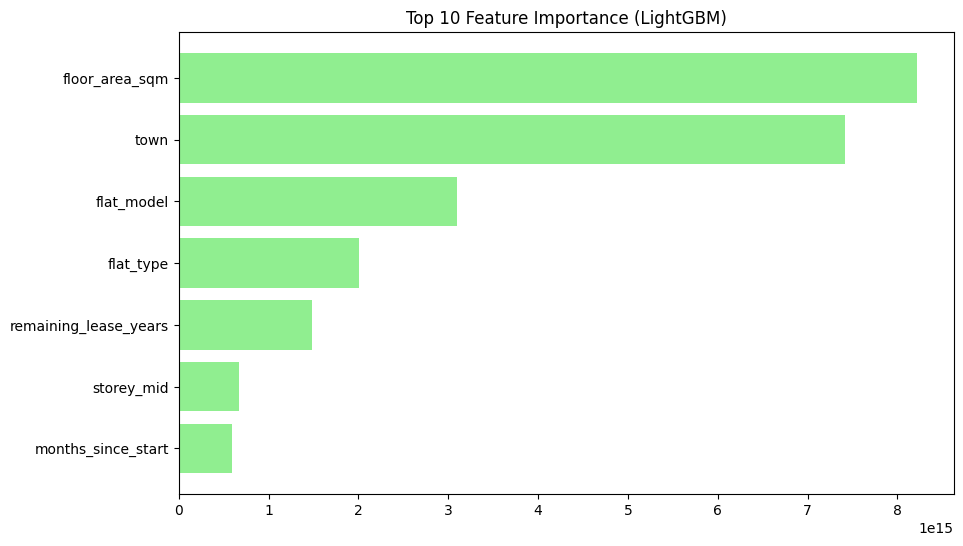

In [227]:
# plot feature importance
importance_df_lgbm = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgbm.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print(importance_df_lgbm)
plt.figure(figsize=(10, 6))
plt.barh(importance_df_lgbm['Feature'], importance_df_lgbm['Importance'], color='lightgreen')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importance (LightGBM)')
plt.show()

# Insights & Strategies to Curb Inflation
Based on the feature importance analysis, here are the data-driven recommendations for the reporting officer:

1. Address the floor area premium (floor_area_sqm)

Observation: Floor area is among single biggest determinant of price (44% based on RandomForestRegressor Importance).

Strategy: Increase the supply of larger flat types (4-Room, 5-Room) in new BTO launches. This suggests a scarcity premium on space; alleviating this scarcity in BTO launches can reduce pressure on the resale market. A middle-ground strategy could be focusing more on 4-room layouts that allow for easier conversion (e.g wall hacking), meeting the demand for space without the costs of a traditional 5-room unit.

2. Targeted cooling measures in areas with high importance (town)

Observation: Specific towns (Bukit Merah, Queenstown, Bishan) appear explicitly in the top 10 features in the RandomForestRegressor and the town ranks the 2nd highest in terms of importance gain in the LightGBM model, indicating location premiums that act independently of flat quality.

Strategy: Implement location-specific cooling measures for resale transactions in these areas to prevent them from setting a high benchmark for the rest of the market.

3. Dynamic MOP for HDBs based on location(remaining lease years)

Observation: Newer flats command significantly higher prices.

Strategy: Dynamically adjust the Minimum Occupation Period (MOP) for BTO builds based on location and the aforementioned feature importance to have targeted dampening of speculative demand for newer launches.

# Model Prediction Task 2

When building an in-house model for users, the following factors and considerations come to mind. (Assumption here that 'in-house' here refers that the model will only be used internally)
1. **Data Governance**
   
   As the model will most likely enriched using non-public data, it becomes more important to not expose internal datasets. Using the Task example, data such as specific buyer/seller demographics etc.

2. **Latency & Scalability**
   
   Both latency and scalability become not a priority, thus we can devote fewer resources towards serving the predictions.
3. **Explainability vs Accuracy**
   
   Public-facing models have a heavy emphasis on the accuracy of the model, whereas in-house models might have need for explainability to inform of current or shifting feature importances. This tasks is one such example where we might value having a more explainable model to inform us of possible inflation curbing policies.

4. **Model Drift & Retraining**

   An in-house model needs a data strategy for retraining to ensure that the data is kept up-to-date with the latest shifts in the housing market. Such a system will also need failsafes in the event that the retrained model performs worst on unseen data. 

5. **Batch vs Inference**
   
   Will need to understand how the model will be used internally as well which would affect how it is deployed. If users need real-time pricing, then the model will have to be hosted on an API service to serve users (latency & scalability also have to be reassessed), if its a monthly report, then scheduling tools such as Airflow can be used to trigger the model to generate predictions.

# Link Analysis Task 1

I have chosen to model the HDB prices as a sequential transactional graph using a directed graph using each individual sale as a node, with the edges connecting the street & flat types from one sale to another in sequence, with an edge weight of the number of days between each sale at the street. This will create a 'transaction' chain that can indicate how much the price has changed since the last sale at the street.

The assumption is that housing paths are path-dependent. A buyer will look at the last transacted price in the street as a benchmark. This "transaction history" link is the strongest causal relation. 

The inclusion of the number of days between each sale gives us an indication of how much 'weight' the immediate previous sale has on the current sale. The assumption is that the longer the time gap between two adjacent nodes, the less influence the previous sale has on the current sale.

In [158]:
import networkx as nx

hdb_prices_graph = hdb_prices_recent.copy()

# generate a unique ID for each listing
hdb_prices_graph['listing_id'] = hdb_prices_graph.index.astype(str)
hdb_prices_graph['date_clean'] = pd.to_datetime(hdb_prices_graph['month'])

In [159]:
hdb_prices_graph.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,date_clean,months_since_start,remaining_lease_years,storey_mid,listing_id
0,2013-01,TOA PAYOH,3_room,107,LOR 1 TOA PAYOH,07 TO 09,67.0,improved,1970,365000.0,NaN,2013-01-01,0,55.916667,8.0,0
1,2013-01,SENGKANG,5_room,236,COMPASSVALE WALK,04 TO 06,123.0,improved,1999,527000.0,NaN,2013-01-01,0,84.916667,5.0,1
2,2013-01,SENGKANG,5_room,296B,COMPASSVALE CRES,07 TO 09,111.0,improved,2002,527000.0,NaN,2013-01-01,0,87.916667,8.0,2
3,2013-01,SENGKANG,5_room,412A,FERNVALE LINK,01 TO 03,114.0,premium_apartment,2004,525000.0,NaN,2013-01-01,0,89.916667,2.0,3
4,2013-01,SENGKANG,5_room,313C,ANCHORVALE RD,01 TO 03,110.0,premium_apartment,2003,523000.0,NaN,2013-01-01,0,88.916667,2.0,4


In [ ]:
# edge construction
#  Sale A (Jan) -> Sale B (Feb) within Block 123
df_sorted = hdb_prices_graph.sort_values(by=['street_name', 'flat_type', 'date_clean'])

# group by block and shift to get the previous listing id
df_sorted['prev_listing_id'] = df_sorted.groupby(['street_name', 'flat_type'])['listing_id'].shift(1)
df_sorted['prev_date'] = df_sorted.groupby(['street_name', 'flat_type'])['date_clean'].shift(1)
# use numeric time difference in days as edge attribute
df_sorted['time_diff_days'] = (df_sorted['date_clean'] - df_sorted['prev_date']).dt.days

# drop first sale of every street (no previous link)
edges_df = df_sorted.dropna(subset=['prev_listing_id'])

edges_with_attr = list(zip(
    edges_df['prev_listing_id'], 
    edges_df['listing_id'],
    edges_df['time_diff_days'].apply(lambda x: {'days': int(x)}) # Attribute Dict
))

In [161]:
G = nx.DiGraph() # directed graph to represent time flow

# Add nodes
for _, row in hdb_prices_graph.iterrows():
    G.add_node(row['listing_id'], 
               price=row['resale_price'], 
            flat_type=row['flat_type'],
               town=row['town'],
               month =row['month'],
               street_name=row['street_name'])

# Add Edges (previous -> current)
G.add_edges_from(edges_with_attr)

print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

Number of Nodes: 149720
Number of Edges: 148078


In [162]:
list(G.nodes(data=True))[:5] 

[('0',
  {'price': 365000.0,
   'flat_type': '3_room',
   'town': 'TOA PAYOH',
   'month': '2013-01',
   'street_name': 'LOR 1 TOA PAYOH'}),
 ('1',
  {'price': 527000.0,
   'flat_type': '5_room',
   'town': 'SENGKANG',
   'month': '2013-01',
   'street_name': 'COMPASSVALE WALK'}),
 ('2',
  {'price': 527000.0,
   'flat_type': '5_room',
   'town': 'SENGKANG',
   'month': '2013-01',
   'street_name': 'COMPASSVALE CRES'}),
 ('3',
  {'price': 525000.0,
   'flat_type': '5_room',
   'town': 'SENGKANG',
   'month': '2013-01',
   'street_name': 'FERNVALE LINK'}),
 ('4',
  {'price': 523000.0,
   'flat_type': '5_room',
   'town': 'SENGKANG',
   'month': '2013-01',
   'street_name': 'ANCHORVALE RD'})]

In [163]:
list(G.edges(data=True))[:5]

[('0', '652', {'days': 0}),
 ('1', '38', {'days': 0}),
 ('2', '20', {'days': 0}),
 ('3', '151', {'days': 0}),
 ('4', '6', {'days': 0})]

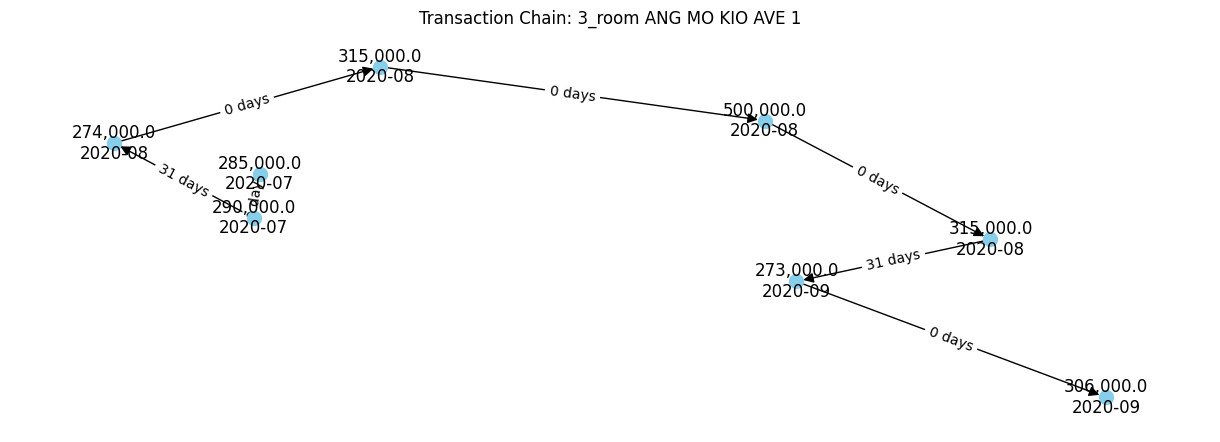

In [234]:
#visualisation of a sample street's transaction chain
#sample_block = df_sorted[df_sorted['town']=='ANG MO KIO'].iloc[1]['block']
sample_street = df_sorted[df_sorted['town']=='ANG MO KIO'].iloc[1]['street_name']
sample_flat_type = df_sorted[df_sorted['town']=='ANG MO KIO'].iloc[1]['flat_type']

# Get all nodes in this specific street and flat type
sample_nodes = df_sorted[
    (df_sorted['flat_type'] == sample_flat_type) & 
    (df_sorted['street_name'] == sample_street)
]['listing_id'].tolist()[-8:]

subgraph = G.subgraph(sample_nodes)

# show edges with time difference attribute

plt.figure(figsize=(12, 4))
pos = nx.spring_layout(subgraph, k=0.5, seed=42)
labels = {node: f"{subgraph.nodes[node]['price']:,}\n{subgraph.nodes[node]['month']}" for node in subgraph.nodes()}
edge_labels = {(u, v): f"{d['days']} days" for u, v, d in subgraph.edges(data=True)}
nx.draw(subgraph, pos, with_labels=True, labels=labels, node_size=100, node_color='skyblue', arrowsize=15)
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
plt.title(f"Transaction Chain: {sample_flat_type} {sample_street}")
plt.show()

# Link Analysis Task 2

**Weakly Connected Components (WCC)**

The algorithm finds the number of subgraphs by traversing (using breadth-first search) from an arbitrary node to every neighbouring node along the edges (both ways), once it is unable to flag any new nodes, it jumps to an undiscovered node and repeats the process until all the nodes are discovered.

The output shows how many streets have extremely high liquidity (very long chains) and which streets have low liquidity (short chains). The plot of the distribution shows is currently more left skewed, which indicates a long tail of highly liquid streets. These large components should show steady incremental price growth, versus the smaller components where a single high sale could cause an inflation shock.

Total Unique Streets (Components): 1642
Avg Transactions per Street: 91.18
Max Chain Length: 1169
Singletons (Streets with only 1 sale): 41


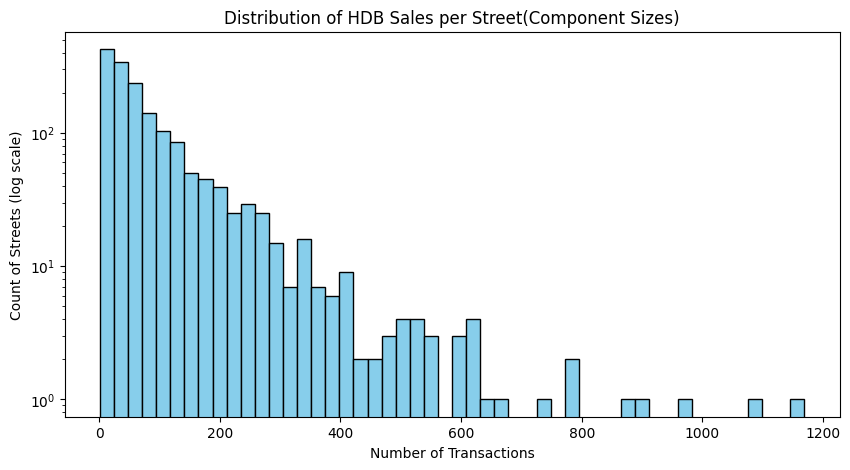

In [ ]:
# Algo 1: Weakly Connected Components Analysis

components = list(nx.weakly_connected_components(G))
component_sizes = [len(c) for c in components]

print(f"Total Unique Streets (Components): {len(components)}")
print(f"Avg Transactions per Street: {sum(component_sizes) / len(components):.2f}")
print(f"Max Chain Length: {max(component_sizes)}")
print(f"Singletons (Streets with only 1 sale): {component_sizes.count(1)}")

plt.figure(figsize=(10, 5))
plt.hist(component_sizes, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of HDB Sales per Street(Component Sizes)')
plt.xlabel('Number of Transactions')
plt.ylabel('Count of Streets (log scale)')
plt.yscale('log') # Log scale because many streets have few sales
plt.show()

In [237]:
# Get list of all components (distinct streets)
components = list(nx.weakly_connected_components(G))
print(f"Total Discrete Streets Analyzed: {len(components)}")

# get 5 most liquid streets and thier flat types
component_sizes = [(len(c), c) for c in components]
component_sizes.sort(reverse=True)
most_liquid_streets = component_sizes[:5]
print("Top 5 Most Liquid Streets and Flat Types:")
for size, comp in most_liquid_streets:
    sample_node = next(iter(comp))
    street_name = G.nodes[sample_node]['street_name']
    flat_type = G.nodes[sample_node]['flat_type']
    print(f"Street: {street_name}, Flat Type: {flat_type}, Transactions: {size}")

Total Discrete Streets Analyzed: 1642
Top 5 Most Liquid Streets and Flat Types:
Street: ANG MO KIO AVE 10, Flat Type: 3_room, Transactions: 1169
Street: YISHUN RING RD, Flat Type: 4_room, Transactions: 1091
Street: ANG MO KIO AVE 3, Flat Type: 3_room, Transactions: 975
Street: YISHUN RING RD, Flat Type: 3_room, Transactions: 893
Street: FERNVALE RD, Flat Type: 4_room, Transactions: 876


In [238]:
# get 5 least liquid streets and thier flat types
least_liquid_streets = component_sizes[-5:]
print("Top 5 Least Liquid Streets and Flat Types:")
for size, comp in least_liquid_streets:
    sample_node = next(iter(comp))
    street_name = G.nodes[sample_node]['street_name']
    flat_type = G.nodes[sample_node]['flat_type']
    print(f"Street: {street_name}, Flat Type: {flat_type}, Transactions: {size}")

Top 5 Least Liquid Streets and Flat Types:
Street: TAMPINES ST 86, Flat Type: 5_room, Transactions: 1
Street: MOH GUAN TER, Flat Type: 4_room, Transactions: 1
Street: HENDERSON RD, Flat Type: 3_room, Transactions: 1
Street: HO CHING RD, Flat Type: 5_room, Transactions: 1
Street: TAMPINES ST 86, Flat Type: 4_room, Transactions: 1


**Node Assortativity**

Assortativity measures the correlation between a node's attributes and its neighbors' attributes. Specifically, we calculate the Price Correlation between a listing and its predecessor.

It does this by going through each edge and forming a pair of its attributes of the connecting nodes (price_A, price_B) for example from Node A to node B. It then calculates the correlation from these values.

The result is a high price assortativity correlation of 0.9270, this confirms that there is strong price momentum, it statistically proves that the price of a unit is heavily influenced to the previous sale in that same street. If the correlation is high, record-breaking sales are dangerous because they immediately pull up the baseline for the entire chain. If the correlation were low, it would imply that other unit attributes (floor, renovation) matter more than the building's recent history.

Conversely, a policy intervention that lowers price will also cascade to future purchases.

In [167]:
# Algo 2: Price Assortativity Analysis
# Calculate numeric assortativity on the 'price' attribute
r = nx.numeric_assortativity_coefficient(G, 'price')
print(f"Price Assortativity (Correlation): {r:.4f}")

Price Assortativity (Correlation): 0.9270
